this notebook makes sure that the rewritten GLM preprocessing pipelines works the same as before.

they are compared against files `glm_fitting_preprocessed_all.hdf5` and `glm_fitting_preprocessed_OT.hdf5` under `/private_data`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tang_jcompneuro import glm_data_preprocessing
import h5py
import os.path
import numpy as np
from tang_jcompneuro import dir_dictionary
from tang_jcompneuro.io import load_image_dataset, neural_dataset_dict

In [3]:
def callback_show(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name, obj.shape)

def list_datasets():
    with h5py.File(os.path.join(dir_dictionary['private_data'], 'glm_fitting_preprocessed_all.hdf5'), 'r') as f:
        f.visititems(callback_show)

In [4]:
list_datasets()

MkA_Shape/half/0/None (9500, 800)
MkA_Shape/half/2/pca_random_sep (9500, 1032)
MkA_Shape/half/4/pca_random_sep (9500, 1032)
MkA_Shape/half/8/pca_random_sep (9500, 1032)
MkA_Shape/half/fpower/None (9500, 400)
MkA_Shape/half/linear/None (9500, 400)
MkA_Shape/y (9500, 1142)
MkE2_Shape/half/0/None (4605, 800)
MkE2_Shape/half/2/pca_random_sep (4605, 1032)
MkE2_Shape/half/4/pca_random_sep (4605, 1032)
MkE2_Shape/half/8/pca_random_sep (4605, 1032)
MkE2_Shape/half/fpower/None (4605, 400)
MkE2_Shape/half/linear/None (4605, 400)
MkE2_Shape/y (4605, 979)


In [5]:
key_mapping = {
    'linear': 'half/linear/None',
    'fpower': 'half/fpower/None',
    'gqm.2': 'half/2/pca_random_sep',
    'gqm.4': 'half/4/pca_random_sep',
    'gqm.8': 'half/8/pca_random_sep',
}


In [6]:
transformer_dict = glm_data_preprocessing.generate_transformer_dict(glm_data_preprocessing.max_total_dim_debug)

In [7]:
transformer_dict

{'fpower': (tang_jcompneuro.glm_data_preprocessing.FPGLMPreprocessor, {}),
 'gqm.2': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 2, 'max_total_dim': 1032}),
 'gqm.4': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 4, 'max_total_dim': 1032}),
 'gqm.8': (tang_jcompneuro.glm_data_preprocessing.GQMPreprocessor,
  {'locality': 8, 'max_total_dim': 1032}),
 'linear': (tang_jcompneuro.glm_data_preprocessing.VanillaGLMPreprocessor, {})}

In [17]:
del transformer_dict['gqm.2']

In [18]:
def check_one_case(neural_dataset, subset):
    # load X in this neural dataset, using legacy method of resizing image.
    image_key = neural_dataset_dict[neural_dataset]['image_dataset_key']
    imageX = load_image_dataset(image_key, trans=True, scale=0.5, subset=subset, legacy_rescale=True)
    imageX_copy = imageX.copy()
    # then generate transformers
    #
    rng_state = np.random.RandomState(seed=0)
    
    for k, (class_this, kwargs) in transformer_dict.items():
        print(k)
        transformer_this: glm_data_preprocessing.GLMDataPreprocesser = class_this(**kwargs)
        transformer_this.get_transformer(imageX)
        explained_var_ratio_cumsum = np.cumsum(transformer_this.per_dim_var)
        X_transed = transformer_this.transform(imageX)
        print(X_transed.shape)
        # assert explained_var_ratio_cumsum.shape == (X_transed.shape[1],)
        
        # compare with reference data.
        with h5py.File(os.path.join(dir_dictionary['private_data'], f'glm_fitting_preprocessed_{subset}.hdf5'), 'r') as f_ref:
            X_transed_ref = f_ref[f'{neural_dataset}/' + key_mapping[k]][...]
            explained_var_ratio_cumsum_ref = f_ref[f'{neural_dataset}/' + key_mapping[k]].attrs['explained_var']
        
        if k in {'linear', 'fpower'}:
            assert explained_var_ratio_cumsum_ref == 1.0
            assert abs(explained_var_ratio_cumsum[-1]-1) < 1e-6
        else:
            assert explained_var_ratio_cumsum_ref.shape == explained_var_ratio_cumsum.shape
            assert abs(explained_var_ratio_cumsum-explained_var_ratio_cumsum_ref).max() < 1e-6
        
        
        assert X_transed.shape == X_transed_ref.shape
        print(abs(X_transed_ref-X_transed).max())
        
        abs(X_transed_ref-X_transed).max()
        
#         if not abs(X_transed_ref-X_transed).max() < 1e-6:
        print(np.sum(abs(X_transed_ref-X_transed)>=1e-6))
        plt.close('all')
        plt.hist(X_transed_ref.ravel()-X_transed.ravel())
        plt.show()
        
        assert abs(X_transed_ref-X_transed).max() < 1e-6
        # finally, (partially) make sure that I did not mistakenly use old data.
        perm_idx_this = rng_state.permutation(imageX.shape[0])
        
        X_transed_debug = np.empty_like(X_transed)
        
#         for idx_aaa, idx_this in enumerate(perm_idx_this):
#             if idx_aaa % 10 == 0:
#                 print(idx_aaa)
#             X_transed_debug[idx_this:idx_this+1] = transformer_this.transform(imageX[idx_this:idx_this+1])
        # break to two blocks
        X_transed_debug[perm_idx_this[:100]] =  transformer_this.transform(imageX[perm_idx_this[:100]])
        X_transed_debug[perm_idx_this[100:]] =  transformer_this.transform(imageX[perm_idx_this[100:]])
        
        assert X_transed.shape == X_transed_debug.shape
        print(abs(X_transed_debug-X_transed).max())
        # this is not zero probably due to blas lib.
        assert abs(X_transed_debug-X_transed).max() < 1e-6
        
        # finally, check statelessness.
        assert np.array_equal(transformer_this.transform(imageX_copy),
                              X_transed)

In [19]:
# check_one_case('MkA_Shape', 'OT')

linear
(9500, 400)
2.02948768901e-13
0


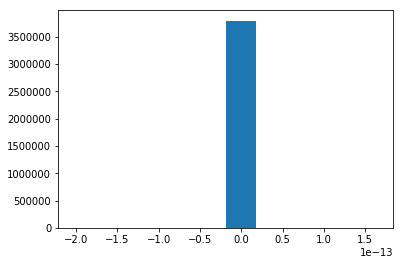

3.5527136788e-15
fpower
(9500, 400)
6.69603261727e-15
0


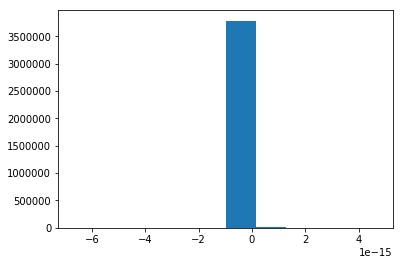

2.77555756156e-16
gqm.4
(9500, 1032)
7.61675028604e-11
0


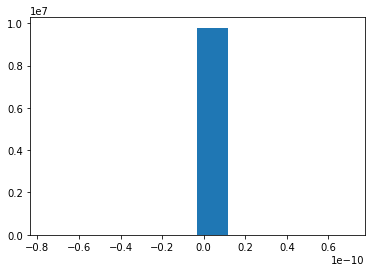

2.84217094304e-14
gqm.8
(9500, 1032)
2.11581863141e-11
0


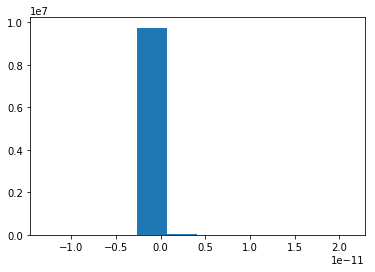

5.68434188608e-14


In [20]:
check_one_case('MkA_Shape', 'all')

In [ ]:
check_one_case('MkE2_Shape', 'OT')

In [ ]:
check_one_case('MkE2_Shape', 'all')